In [1]:
import os
import json
import gc

import cv2
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, Activation, Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# load dataframe with train labels

In [2]:
train_df = pd.read_csv('../input/severstal-steel-defect-detection/train.csv')
print(train_df.shape)

(7095, 3)


In [3]:
train_df.head(5)

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7095 entries, 0 to 7094
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        7095 non-null   object
 1   ClassId        7095 non-null   int64 
 2   EncodedPixels  7095 non-null   object
dtypes: int64(1), object(2)
memory usage: 166.4+ KB


In [5]:
list(train_df['ClassId'].unique())

[1, 3, 4, 2]

In [6]:
mask_count_df = train_df.groupby('ImageId')["ClassId"].count().reset_index().rename(columns = {"ClassId":"Num_ClassId"})
mask_count_df.sort_values('Num_ClassId', ascending=False, inplace=True)
print(mask_count_df.shape)
mask_count_df.head()

(6666, 2)


,ImageId,Num_ClassId
6253,ef24da2ba.jpg,3
5740,db4867ee8.jpg,3
3435,84865746c.jpg,2
2203,5665ada1b.jpg,2
6149,eb44ad79d.jpg,2


# Keras U-Net

## Utility Functions

In [7]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    starts-=1
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T


def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

## Data Generator

In [8]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='../input/severstal-steel-defect-detection/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=4, random_state=2021, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            img = self.__load_grayscale(img_path)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            #print()
            #print("i",i)
            #print("ID",ID)
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name].copy().reset_index()
            #print("image_df:",image_df)

            masks = np.zeros((*self.dim, self.n_classes))
            
            for j in range(len(image_df)):
                #print(j)
                rle = image_df.loc[j,'EncodedPixels']
                cls =  image_df.loc[j,'ClassId']
                masks[:, :, cls-1] = rle2mask(rle, self.dim)
    
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img

In [9]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    mask_count_df.index, 
    random_state=2021, 
    test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

val_generator = DataGenerator(
    val_idx, 
    df=mask_count_df,
    target_df=train_df,
    batch_size=BATCH_SIZE, 
    n_classes=4
)

## Model

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [11]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [12]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [13]:
input_img = Input((256, 1600, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

#model = get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True)

#build_model((256, 1600, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 1600, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 1600, 16 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 1600, 16 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 1600, 16 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
mc = ModelCheckpoint(
    'model.h5', 
    #monitor='val_dice_coef', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
    #mode='max'
)


es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=40)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[dice_coef])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    callbacks=[mc,es],
    verbose=2, 
    epochs=80
)

Epoch 1/80
354/354 - 309s - loss: 0.2019 - dice_coef: 0.0562 - val_loss: 0.0863 - val_dice_coef: 0.0678

Epoch 00001: val_loss improved from inf to 0.08632, saving model to model.h5
Epoch 2/80
354/354 - 284s - loss: 0.0547 - dice_coef: 0.2126 - val_loss: 0.0482 - val_dice_coef: 0.2028

Epoch 00002: val_loss improved from 0.08632 to 0.04820, saving model to model.h5
Epoch 3/80
354/354 - 284s - loss: 0.0399 - dice_coef: 0.3183 - val_loss: 0.0358 - val_dice_coef: 0.3903

Epoch 00003: val_loss improved from 0.04820 to 0.03581, saving model to model.h5
Epoch 4/80
354/354 - 284s - loss: 0.0346 - dice_coef: 0.3821 - val_loss: 0.0381 - val_dice_coef: 0.3939

Epoch 00004: val_loss did not improve from 0.03581
Epoch 5/80
354/354 - 283s - loss: 0.0319 - dice_coef: 0.4227 - val_loss: 0.0309 - val_dice_coef: 0.4432

Epoch 00005: val_loss improved from 0.03581 to 0.03087, saving model to model.h5
Epoch 6/80
354/354 - 284s - loss: 0.0305 - dice_coef: 0.4487 - val_loss: 0.0289 - val_dice_coef: 0.4835


In [15]:
def history_plot(model_id, history1):
	plt.figure(figsize=(14,16)) 
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss - ' + model_id, fontsize = 12)
	plt.plot(history1.history['loss'], color='blue', label='train base')
	plt.plot(history1.history['val_loss'], color='cyan', label='val base')
	plt.xlabel("Epochs",fontsize = 12)
	plt.ylabel("Loss", fontsize = 12)
	plt.legend(loc='upper right')

	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy ' + model_id, fontsize = 10)
	plt.plot(history1.history['dice_coef'], color='blue', label='train base')
	plt.plot(history1.history['val_dice_coef'], color='cyan', label='val base')
	plt.xlabel("Epochs", fontsize = 12)
	plt.ylabel("dice_coef", fontsize = 12)
	plt.legend(loc='lower right')

	plt.show()

In [16]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])

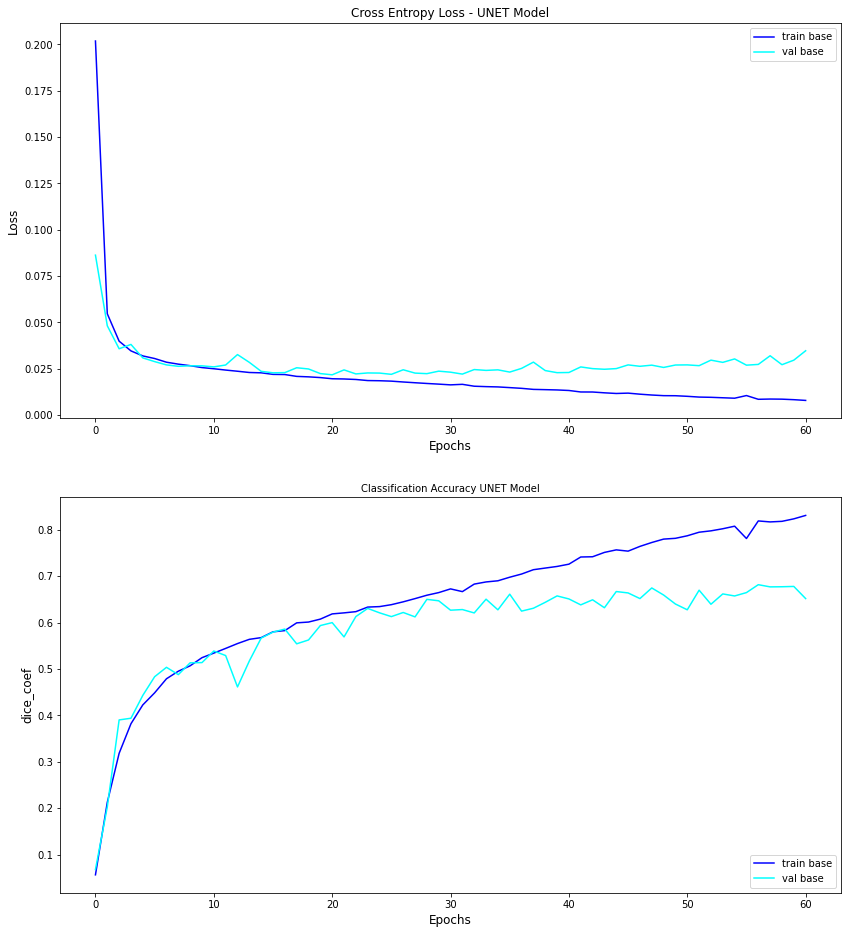

In [17]:
history_plot('UNET Model', history)

In [18]:
model.load_weights('model.h5')

In [19]:
model.save('severstal-segmentation_unetBN.h5', save_format="h5")

## References：
+ Data generator: 
        * https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
        * https://www.kaggle.com/ripcurl/severstal-unet-with-efficientnetb4-keras
+ RLE encoding and decoding: https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
+ Mask encoding: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data
